In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils import get_root_dir

### This Notebook will be used to test models for time-series forecasting on crime data

In [2]:
get_root_dir()

'/home/jamie/code/JamieW365/londoncrime'

In [3]:
df_crime = pd.read_csv(os.path.join(get_root_dir(), 'data/processed/final.csv'))
df_crime.head()

,Major,Minor,Borough,Date,Count,Population
0,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-04-01,6.0,182838
1,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-05-01,5.0,182838
2,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-06-01,11.0,182838
3,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-07-01,10.0,182838
4,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-08-01,6.0,182838


In [4]:
df_crime['Count_Per_1000'] = df_crime['Count'] / (df_crime['Population'] / 1000)

In [5]:
total_crime_trend = df_crime.groupby('Date').sum(numeric_only=True)['Count_Per_1000']
total_crime_trend

Date
2010-04-01    268.322545
2010-05-01    274.519513
2010-06-01    277.427047
2010-07-01    281.972314
2010-08-01    261.862011
                 ...    
2023-07-01    273.811522
2023-08-01    262.543980
2023-09-01    263.757539
2023-10-01    280.749514
2023-11-01    271.461315
Name: Count_Per_1000, Length: 164, dtype: float64

<Axes: xlabel='Date'>

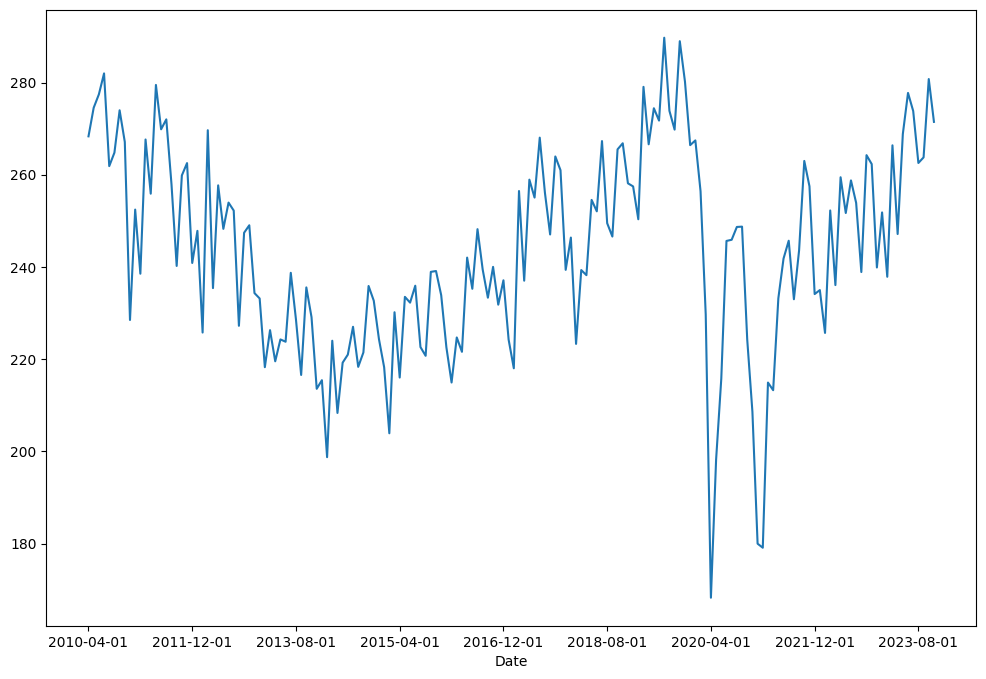

In [6]:
total_crime_trend.plot(figsize=(12,8))

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

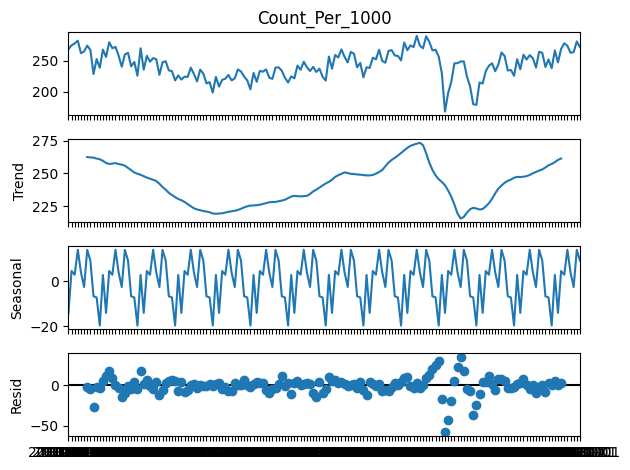

In [55]:
seasonal_decomp = seasonal_decompose(x=total_crime_trend, model="additive", period=12)
seasonal_decomp.plot();

In [42]:
df_train = total_crime_trend.head(int(len(total_crime_trend) * 0.7)).copy()
df_test = total_crime_trend.drop(df_train.index).copy()

total_crime_trend.shape, df_train.shape, df_test.shape

((164,), (114,), (50,))

<Axes: xlabel='Date'>

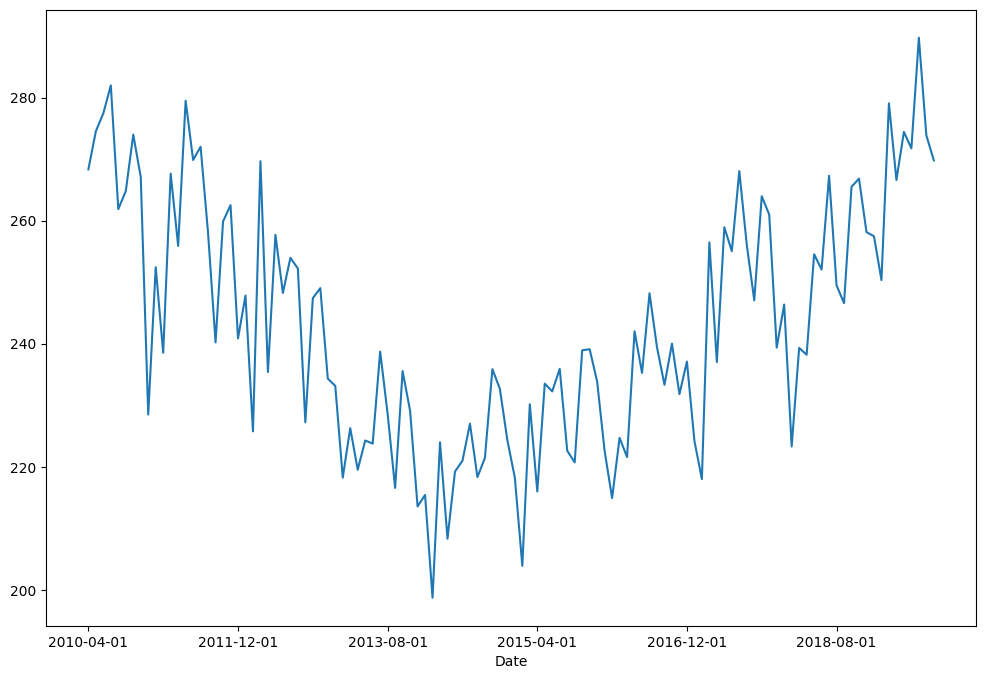

In [43]:
df_train.plot(figsize=(12, 8))

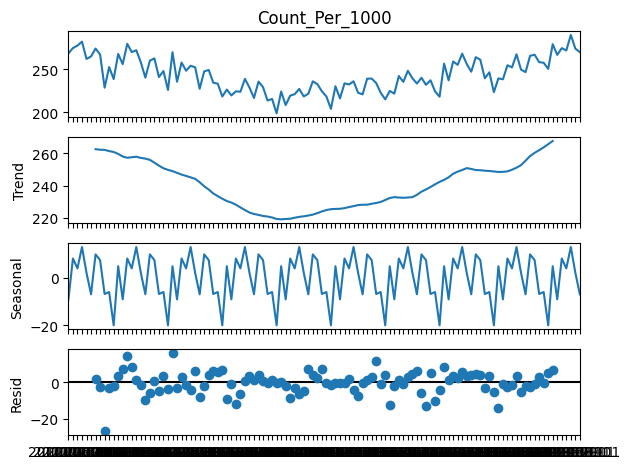

In [44]:

seasonal_decomp = seasonal_decompose(x=df_train, model="additive", period=12)
seasonal_decomp.plot();

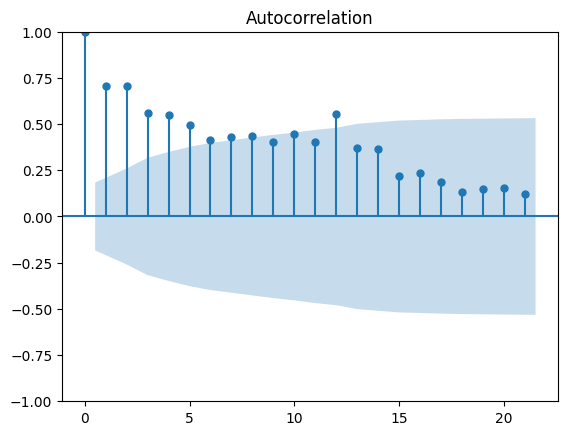

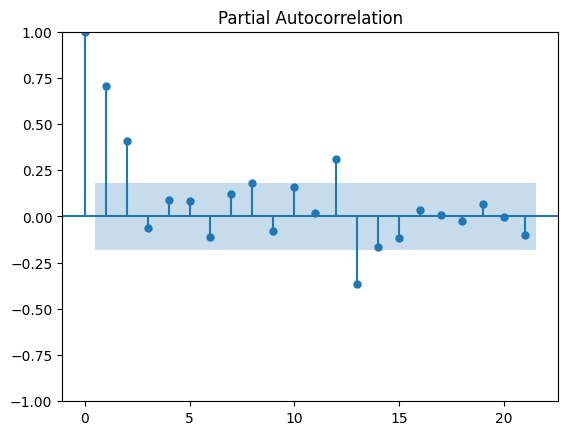

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

## ADF test for stationarity

In [13]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_train)
print(f'p-value : {adf_test[1]}')

p-value : 0.7676534986153568


## Transforming data to stationary

0.0015549701464487031


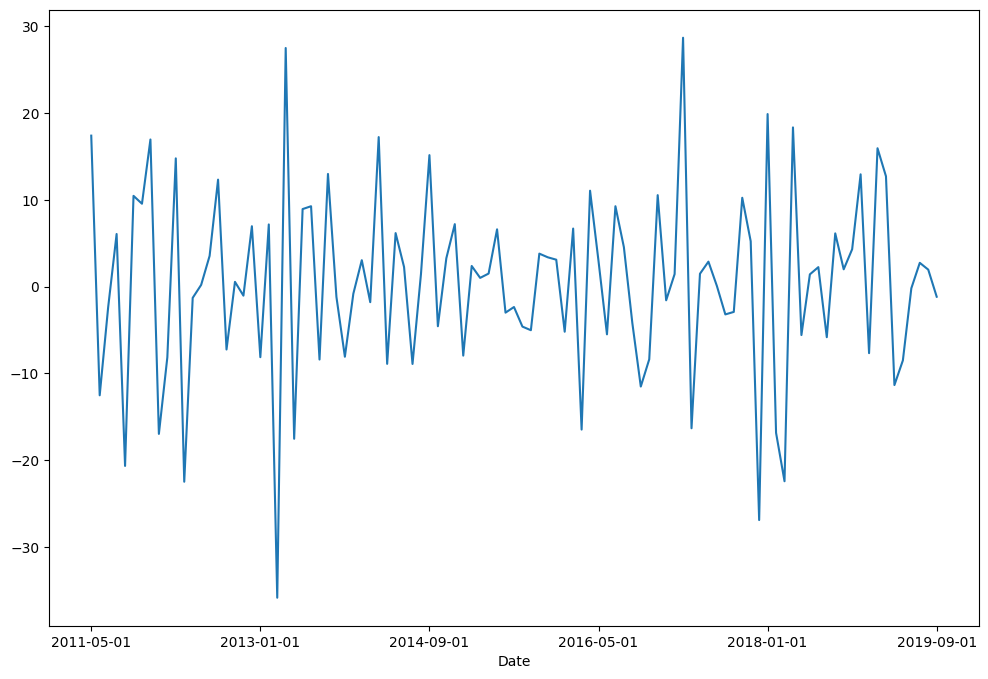

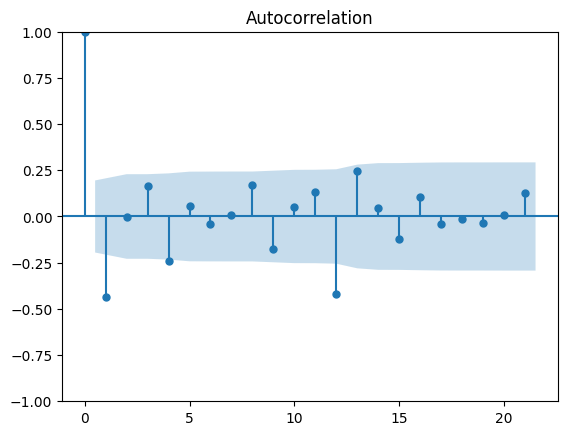

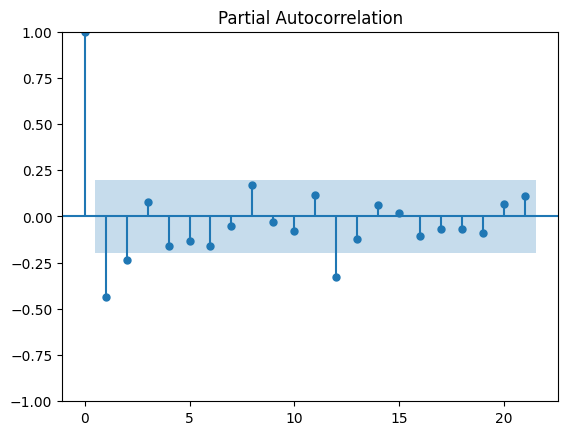

In [34]:
df_train_diff = df_train.diff(12).diff(1).dropna()

print(adfuller(df_train_diff)[1])

df_train_diff.plot(figsize=(12,8))

acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

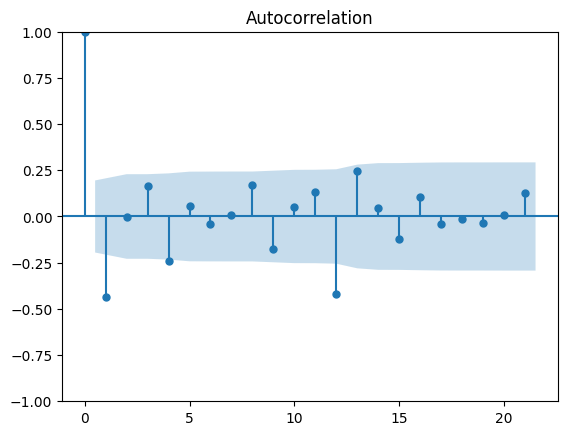

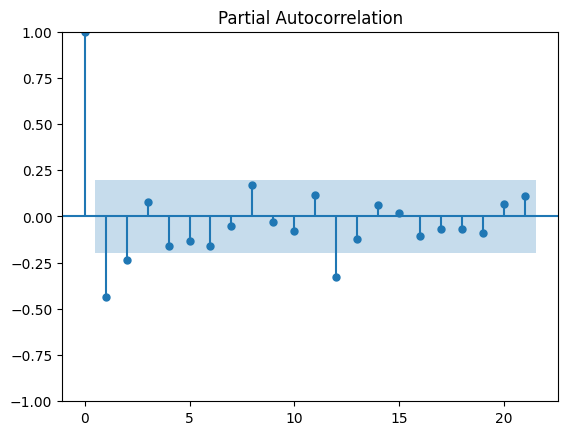

In [35]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

## Fit ARIMA Model

In [36]:
from statsmodels.tsa.arima.model import ARIMA

In [37]:
model = ARIMA(df_train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Count_Per_1000   No. Observations:                  114
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -446.870
Date:                Wed, 03 Apr 2024   AIC                            899.741
Time:                        21:14:16   BIC                            907.923
Sample:                    04-01-2010   HQIC                           903.061
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5659      0.122     -4.648      0.000      -0.805      -0.327
ar.L2         -0.0664      0.098     -0.676      0.499      -0.259       0.126
sigma2       158.9046     19.997      7.947      0.0

## Check Model Residuals

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

In [ ]:
acf_resid = plot_acf(residuals)

pacf_resid = plot_pacf(residuals)

## Forecasting with fitted model

In [ ]:
df = pd.DataFrame(total_crime_trend)
df.drop('forecast', inplace=True)
df

In [ ]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast'] = [None]*len(df_train) + list(forecast_test)

df.plot()

In [ ]:
forecast_test